# Bayesian Optimization Tutorial

**Module 3: The BO Feedback Loop**
*   Instructor: Joel Paulson, Department of Chemical and Biomolecular Engineering, The Ohio State University
*   Date: 04/15/23
*   Location: Great Lakes PSE Student Workshop

# Notebook Overview

This notebook creates an example black-box system and your goal will be to optimize it using the BO methods we have learned about so far. You should be prepared to use the two helper functions that we constructed at the end of Modules 1 and 2. 

# Install Packages (Setup)

Note all the packages come installed in Google Colab, so run the code below to install external packages.

In [1]:
!pip install casadi
!pip install do_mpc
!pip install botorch
!pip install scikit-quant

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 MB 9.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 1.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.8/521.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 23.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject

Load all the packages that we will need in this notebook.

In [2]:
import numpy as np
import sys
from casadi import *
import pdb
import do_mpc
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.animation import FuncAnimation, FFMpegWriter, ImageMagickWriter
import math
import gpytorch
import botorch
import torch
torch.set_default_dtype(torch.float64)
from botorch.utils.sampling import draw_sobol_samples
from torch.quasirandom import SobolEngine
from gpytorch.kernels import MaternKernel, ScaleKernel, RBFKernel, LinearKernel, PeriodicKernel
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound, PosteriorMean
from botorch.optim import optimize_acqf
from botorch.sampling import SobolQMCNormalSampler
from gpytorch.constraints.constraints import Interval
from gpytorch.likelihoods.gaussian_likelihood import GaussianLikelihood
from gpytorch.constraints import GreaterThan
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from botorch.optim import optimize_acqf
import time
from scipy import optimize
from skquant.opt import minimize as skqmin

# turn off warnings for clean output
import warnings
warnings.filterwarnings('ignore')

Run the code block below without looking at the code.

In [3]:
#@title
B_true = [0.014,   0.063,   0.221,  0.367]

# Problem Description

## Closed-loop Simulator

We are interested in controlling a system of 2 masses connected horizontally by springs, with walls on either end, as depicted in the figure below. The state of the system is $(s_1, v_1, s_2, v_2)$ where $s_i$ refers to the displacement of mass $i$ from its steady state and $v_i$ refers to the velocity of mass $i$. A force can be applied to the second mass, denoted by $u_1$, that can be used to dampen the oscillations. An approximate linear time-invariant system model $x_{t+1} = Ax_t + Bu_t$ can be developed as discussed [here](https://www.do-mpc.com/en/latest/example_gallery/oscillating_masses_discrete.html).

<div>
<img src="https://drive.google.com/uc?export=view&id=1avVtHoMAvO-1O3zP8xMSdyyZuzahL6Tl" width="650"/>
</div>

Since there are constraints present in the system, we use a model predictive control (MPC) strategy to take feedback from the measured states to compute the optimal input to apply at every iteration. What makes this problem particularly tricky in our setting is that we assume that we only know part of the system dynamics -- the matrix $A$ to be exact. Therefore, we will treat the $B$ matrix in our MPC as "tuning parameters" that we want to learn with BO. 

Below we define our simulator code. Do not worry about the details, as we are simply treating this as a black-box system. The simulator takes in the following arguments:

* ```B``` -- this is the set of values in the $B$ matrix, which corresponds to a 4-element vector. 
* ```get_mpc``` -- this is an optional argument that we can use to get plotting information, as we will show next. 

In [4]:
#@title
from numpy.matrixlib import bmat
e = np.ones([4,1])
np.random.seed(0)
x00 = np.random.uniform(-3*e,3*e) # Values between +3 and +3 for all states

model_type = 'discrete' # either 'discrete' or 'continuous'
true_model = do_mpc.model.Model(model_type)

_x = true_model.set_variable(var_type='_x', var_name='x', shape=(4,1))
_u = true_model.set_variable(var_type='_u', var_name='u', shape=(1,1))

A = np.array([[ 0.763,  0.460,  0.115,  0.020],
              [-0.899,  0.763,  0.420,  0.115],
              [ 0.115,  0.020,  0.763,  0.460],
              [ 0.420,  0.115, -0.899,  0.763]])

B = np.array([[B_true[0]],   [B_true[1]],   [B_true[2]],  [B_true[3]]])

x_next = A@_x + B@_u

true_model.set_rhs('x', x_next)
true_model.set_expression(expr_name='cost', expr=sum1(_x**2))
true_model.setup()

def closedloop_sim(B, specified_theta0=None, get_mpc=False):

  # first, build that control model, which may have mismatch to the true system
  model_type = 'discrete' # either 'discrete' or 'continuous'
  model_wMismatch = do_mpc.model.Model(model_type)
  
  _x = model_wMismatch.set_variable(var_type='_x', var_name='x', shape=(4,1))
  _u = model_wMismatch.set_variable(var_type='_u', var_name='u', shape=(1,1))

  Am = np.array([[ 0.763,  0.460,  0.115,  0.020],
                [-0.899,  0.763,  0.420,  0.115],
                [ 0.115,  0.020,  0.763,  0.460],
                [ 0.420,  0.115, -0.899,  0.763]])

  Bm = np.array([ [B[0]],   [B[1]],   [B[2]],  [B[3]] ]) # use our guess values
  
  x_next = Am@_x + Bm@_u

  model_wMismatch.set_rhs('x', x_next)
  model_wMismatch.set_expression(expr_name='cost', expr=sum1(_x**2))
  model_wMismatch.setup()

  # now, lets set up the controller, using our mismatched model
  mpc_m = do_mpc.controller.MPC(model_wMismatch)

  setup_mpc = {
    'n_robust': 0,
    'n_horizon': 7,
    't_step': 0.5,
    'state_discretization': 'discrete',
    'store_full_solution':True,
    # Use MA27 linear solver in ipopt for faster calculations:
    'nlpsol_opts': {'ipopt.linear_solver': 'mumps',
                    'ipopt.print_level':0,
                    'print_time':0,
                    'ipopt.sb': 'yes',
                    },
  }
  mpc_m.set_param(**setup_mpc)

  mterm = model_wMismatch.aux['cost'] # terminal cost
  lterm = model_wMismatch.aux['cost'] # stage cost
  mpc_m.set_objective(mterm=mterm, lterm=lterm)
  mpc_m.set_rterm(u=1e-4) # input penalty

  # define state bounds
  max_x = np.array([[4.0], [10.0], [4.0], [10.0]])
  # lower bounds of the states
  mpc_m.bounds['lower','_x','x'] = -max_x
  # upper bounds of the states
  mpc_m.bounds['upper','_x','x'] = max_x
  # lower bounds of the input
  mpc_m.bounds['lower','_u','u'] = -0.5
  # upper bounds of the input
  mpc_m.bounds['upper','_u','u'] =  0.5

  # run setup
  mpc_m.setup()

  # define an estimator 
  # (in this case, full state feedback, so the estimator is just an identity) 
  estimator = do_mpc.estimator.StateFeedback(true_model)

  # set inital state
  x_0 = x00
  if specified_theta0 is not None:
    x_0 = specified_theta0.numpy() 
  mpc_m.x0 = x_0
  mpc_m.set_initial_guess()

  x0 = x_0
  thetas = [x0[:]]
  
  # set up simulator
  simulatorCL = do_mpc.simulator.Simulator(true_model)
  simulatorCL.set_param(t_step = 0.5)
  simulatorCL.setup()

  # specify I.C. for closed loop simulator
  if specified_theta0 is None:
    simulatorCL.x0 = x0 
  else: 
    simulatorCL.x0 = casadi.DM(specified_theta0.numpy())
  simulatorCL.setup()

  # Run Closed-loop simulator 
  n_steps = 40
  for k in range(n_steps):
      try: 
        u0 = mpc_m.make_step(x0)
        y_next = simulatorCL.make_step(u0)
      except:
        print('!!!!!!      ', k,'      !!!!!!' )
        print("Failed to find a fesible control action and simulator crashed... ")
        print("...retrying with purturbed control action ")
        y_next = simulatorCL.make_step(u0*.99)

      x0 = estimator.make_step(y_next)
      thetas.append(x0[:])

  sol = np.sum( (mpc_m.data['_x'])**2 )

  if get_mpc == False:
    return sol, thetas
  else:
    return sol, thetas, mpc_m

Let's test that our simulator works by running it for the true values. 

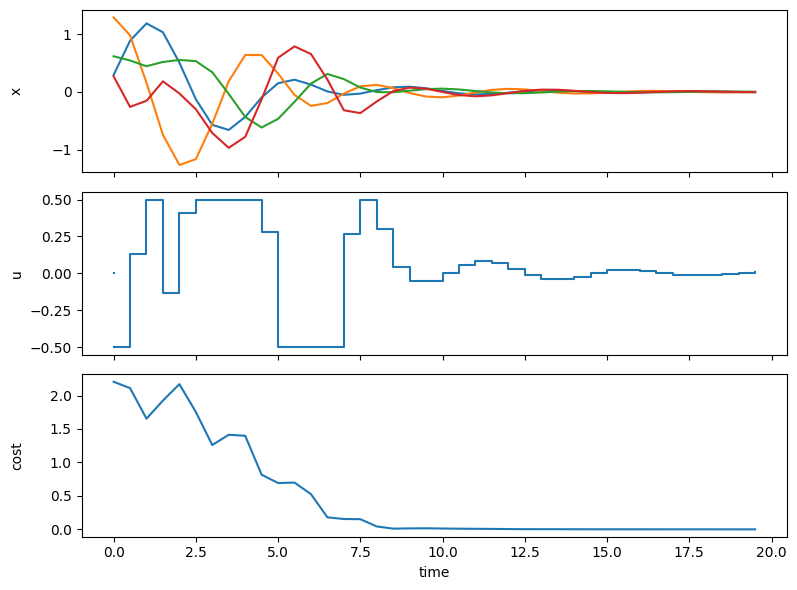

Closed-loop score with true B values: 19.24608719529267


In [5]:
# test the closed loop
true_cost, thetas_good, mpc_true = closedloop_sim(B.flatten(), get_mpc=True)
fig, ax, graphics = do_mpc.graphics.default_plot(mpc_true.data, figsize=(8,6))
graphics.plot_results()
graphics.reset_axes()
plt.show()
print('Closed-loop score with true B values:', true_cost);

## Try to Manually Tune the Controller

The values in $B$ can all vary between 0 and 1, such that our domain $\Omega = [0,1]^4$. Try to select some values and run the closed-loop system below to see if you can get good performance. 

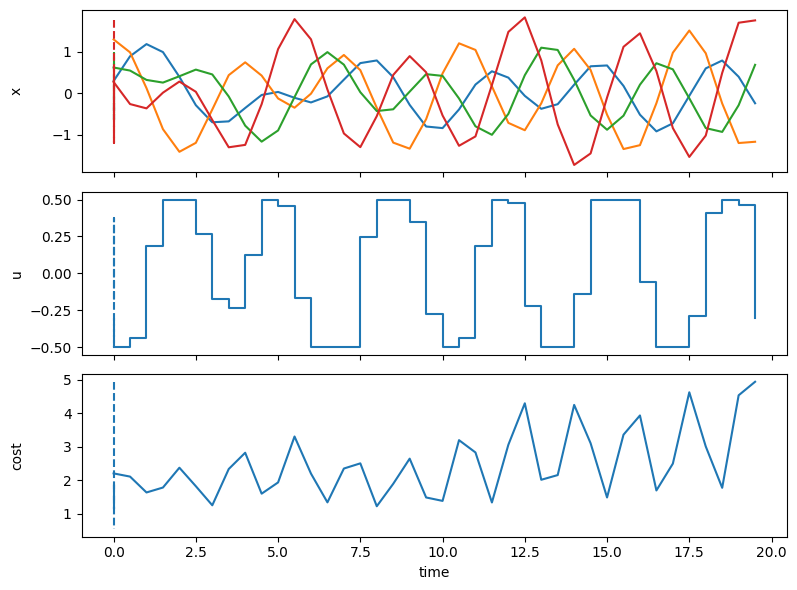

Closed-loop score with guessed B values: 100.31665184442761


In [6]:
# Try some guesses for B and see how well you can do in terms of performance
B_guess = [0.0, 1.0, 1.0, 0.0]
cost_guess, _, mpc_guess = closedloop_sim(B_guess, get_mpc=True)
fig, ax, graphics = do_mpc.graphics.default_plot(mpc_guess.data, figsize=(8,6))
graphics.plot_results()
graphics.reset_axes()
plt.show()
print('Closed-loop score with guessed B values:', cost_guess);

# Setup Your Own BO Loop

Now, your goal is to define your own BO loop based on the principles we learned in Module 3. The key steps are:

1. Train a GP model given the most recent data.

2. Define a suitable acquisition function (that represents roughly value of information).

3. Maximize acquisition function to identify next best sample point.

4. Query function at sample and add to data history.

We can use the helper functions that we constructed in Modules 1 and 2 to help build the loop, so let's load those below. 

The recommended point is 0.0
The acquisition function is 0.08187362474324464


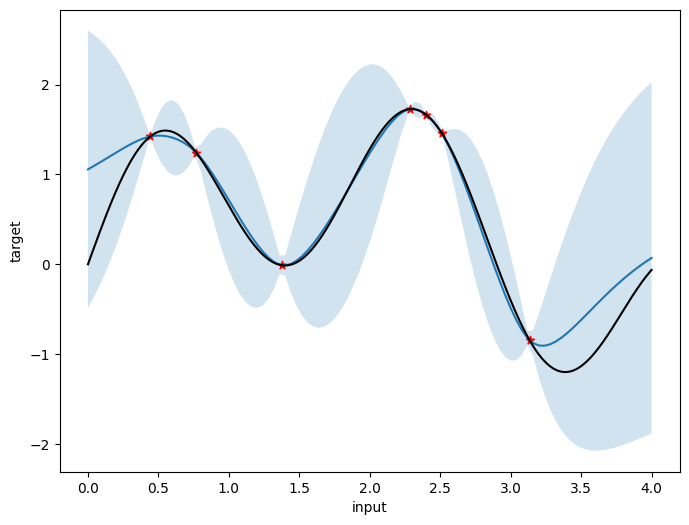

In [7]:
# Helper function that takes input data, kernel+likelihood specifications, and plotting options --> return trained model
def get_trained_GP(X, Y, kernel_type, noise_free=False, plot_1d=False, plot_bounds=None):
    """
    This function is used to train a GP model based on the type of kernel that you select.
    This function will be used in modules 1,2,and 3. Save this function for later
    If you delete this cell accidentally, let us know!

    -----------
    Arg:
    X: Features/ Input vector -- torch tensor 
    Y: Mapping/ Target variable vector -- torch tensor
    kernel_type: 'RBF'/'Linear'/'Periodic'/'Matern05'/'Matern15'/'Matern25' select one -- str
    noise_free: True or False (are observations noise free?)
    plot_1d: True or False (should we plot or not?)
    plot_bounds: Tuple of lower and upper bounds (xL, xU)

    ----------
    returns:

    model: a GP model object in train mode -- gpytorch
    """  

    # make sure input data is shaped properly (ntrain by ninputs)
    if X.ndim < 2:
      print("Need to specify as matrix of size ntrain by ninputs")

    # make sure training data has the right dimension
    if Y.ndim == 1:
        Y = Y.unsqueeze(-1)

    # output scaling
    standardize = Standardize(m=Y.shape[-1])
    outcome_transform = standardize

    # select covariance module
    input_dim = X.shape[-1]
    if kernel_type == 'RBF':
        covar_module = ScaleKernel(RBFKernel(ard_num_dims=input_dim))
    elif kernel_type == 'Linear':
        covar_module = ScaleKernel(LinearKernel(ard_num_dims=input_dim))
    elif kernel_type == 'Periodic':
        covar_module = ScaleKernel(PeriodicKernel(ard_num_dims=input_dim))
    elif kernel_type == 'Matern05':
        covar_module = ScaleKernel(MaternKernel(nu=0.5, ard_num_dims=input_dim))
    elif kernel_type == 'Matern15':
        covar_module = ScaleKernel(MaternKernel(nu=1.5, ard_num_dims=input_dim))
    elif kernel_type == 'Matern25':
        covar_module = ScaleKernel(MaternKernel(nu=2.5, ard_num_dims=input_dim))

    # set the likelihood
    if noise_free:
      likelihood = GaussianLikelihood(noise_constraint=Interval(lower_bound=1e-5, upper_bound=1e-3))
    else:
      likelihood = GaussianLikelihood(noise_constraint=Interval(lower_bound=1e-5, upper_bound=100))

    # define the model
    model = SingleTaskGP(train_X=X, train_Y=Y, covar_module=covar_module, likelihood=likelihood, outcome_transform=outcome_transform)

    # call the training procedure
    model.outcome_transform.eval()
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)

    # put in eval mode
    model.eval()

    # plot if specified 
    if plot_1d:
      if input_dim == 1:
        if plot_bounds is None:
          print("Plot bounds not specified!")
        else:
          x_list = torch.linspace(plot_bounds[0], plot_bounds[1], 101)
          preds = model.posterior(x_list.unsqueeze(-1))
          mean = preds.mean.squeeze()
          var = preds.variance.squeeze()
          lcb = mean - 2*torch.sqrt(var)
          ucb = mean + 2*torch.sqrt(var)
          plt.figure(figsize=(8,6))
          plt.plot(x_list, mean.detach().numpy())
          plt.fill_between(x_list, lcb.detach().numpy(), ucb.detach().numpy(), alpha=0.2)
          plt.scatter(X.detach().numpy(), Y.detach().numpy(), color ='red', marker ='*')
          plt.xlabel('input')
          plt.ylabel('target')
      else:
        print("Too many input dimensions to plot!")

    # return the trained model
    return model

# Helper function that allows you to maximize acquisition function
def optimize_my_acqf(acq, xL, xU, num_restarts=10, raw_samples=1000):
    """
    This function is used to select an acquisition function and select the best point based on the information.
    This function will be used in modules 2 and 3. Save this function for later
    If you delete this cell accidentally, let us know!

    -----------
    Args:
    acq: the specified acquisition function -- botorch class
    xL: Lower limit of X (input variables) -- torch tensor (1d)
    xU: Upper limit of Y (output variables) -- torch tensor (1d)
    num_restarts: Number of multi-starts to perform -- integer
    raw_samples: Number of random initial samples to use to generate multi-start candidates

    ----------
    returns:

    new_point : next point (x) to sample to obtain f(x) -- torch tensor    
    acq_val : the value of the acquisition function at this point -- torch tensor    
    """  

    # write out bounds in botorch notation
    nx = xL.shape[0]
    bounds = torch.tensor([(xL[j], xU[j]) for j in range(nx)]).T

    # run the optimization routine and extract the required values
    new_point, acq_value_list = optimize_acqf(acq_function=acq, bounds=bounds, q=1, num_restarts=num_restarts, raw_samples=raw_samples, options={})
    try:
      acq_val = acq_value_list.numpy()
      
    except:
      print('Optimizing the acqusition failed, so taking single random point')
      new_point = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(1, nx)
      acq_val = float('nan')

    return new_point, acq_val

## Test these functions are working

# write a simple 1d function [feel free to modify]
f = lambda x: torch.sin(x) + torch.sin((10.0 / 3.0) * x)

# define input range
x_min, x_max = 0.0, 4.0

# generate some number of random data points
Ninit = 7
torch.manual_seed(8)
x_train = (x_max-x_min)*torch.rand((Ninit,1)) + x_min
y_train = f(x_train)

# fit model
model = get_trained_GP(x_train, y_train, 'Matern15', noise_free=True, plot_1d=True, plot_bounds=(x_min, x_max))
xlist = torch.linspace(x_min, x_max, 1001)
plt.plot(xlist, f(xlist), '-k');

# optimize ei
best_value = y_train.max()
ei = ExpectedImprovement(model=model, best_f=best_value, maximize=True)
new_x, acq_val = optimize_my_acqf(ei, torch.tensor([x_min]), torch.tensor([x_max]))
print(f"The recommended point is {new_x.detach().numpy().squeeze()}")
print(f"The acquisition function is {acq_val}")

Fill in the loop below.

In [ ]:
# generate some initial data (uniform random samples), store data

# loop over number of iterations

  # train model using most recent data

  # maximize acquisition function to get next suggested point

  # evaluate the function

  # append new data to your data history

# Pre-compiled Results

## Setup Runs

In [8]:
# User parameters
nreps = 1         # number of full optimiztion rounds
total_evals = 50  # num total budget (includes n_init)
n_init = 5        # num init samples
n_sa = 1          # num sample avg

# Data for BO method
BO_losses = torch.zeros(nreps, total_evals-n_init)
BO_Bvec  = torch.zeros(nreps, total_evals-n_init, 4)
BO_y     = torch.zeros(nreps, total_evals-n_init)

# Data for random search method
RD_losses = torch.zeros(nreps, total_evals)
RD_Bvec  = torch.zeros(nreps, total_evals, 4)
RD_y     = torch.zeros(nreps, total_evals)

# Data for Snobfit method 
SF_losses = torch.zeros(nreps, total_evals)
SF_Bvec  = torch.zeros(nreps, total_evals, 4)
SF_y     = torch.zeros(nreps, total_evals)

# Fix seed
np.random.seed(0)
rand_ic = torch.tensor(np.random.uniform(-3*e,3*e, (4,n_sa)))

# Evaluate true score
ts = 0
for i in range(n_sa):
  ts+= closedloop_sim(B_true, rand_ic[:,i])[0]
True_Score = ts/n_sa
print(True_Score)

19.24608719529267


## A BO Loop

In [9]:
# loop over replicates
for j in range(nreps):
  # bounds
  bounds = torch.tensor([[0]*4, [1]*4]).double()
  dim = bounds.shape[1]

  # generate some random initial data 
  torch.random.manual_seed(0)
  sobol = SobolEngine(dimension=dim, scramble=True, )
  train_x = torch.empty(total_evals, dim)
  train_x[:n_init,:] = sobol.draw(n=n_init)
  train_x[:n_init,:] = train_x[:n_init,:]*(bounds[1]-bounds[0])+bounds[0]

  # evaluate function at random samples
  train_y = torch.empty(total_evals, 1)
  for i in range(n_init):
    yi = 0
    for ii in range(n_sa):
     yi += closedloop_sim(train_x[i,:].numpy(),  rand_ic[:,ii])[0]
     train_y[i,:] = yi/n_sa

  BO_losses[j, 0] = train_y[:n_init,:].min().item()
  for k in range(total_evals-n_init-1):
      #fit model
      model = get_trained_GP(train_x[:k+n_init,:], train_y[:k+n_init,:], 'RBF', noise_free=True)

      #build and opt EI Acq fun
      best_value = y_train.min()
      ei = ExpectedImprovement(model=model, best_f=best_value, maximize=False)
      candidates, acq_val = optimize_acqf(ei, bounds=bounds, q=1, num_restarts=10, raw_samples=1000)
      
      # observe new values 
      new_x = candidates.detach()
      train_x[k+n_init,:] = new_x
      yi = 0
      for i in range(n_sa):
        yi += closedloop_sim(new_x.numpy().flatten(), rand_ic[:,i])[0]
      train_y[k+n_init,:] = yi/n_sa

      # save results
      BO_losses[j,k+1]    = train_y[:k+n_init,:].min().item()
      BO_Bvec[j,k+1, :]   = new_x
      BO_y[j,k+1]         = train_y[k+n_init,:].item() 

      # print current results
      print("Round %03d --- it: %03d, loss: %3.3f, best: %3.3f" % 
            (j+1, 
             k+1, 
             train_y[k+n_init,:].item(),  
             train_y[:k+n_init,:].min().item() ))

Round 001 --- it: 001, loss: 45.626, best: 27.993
Round 001 --- it: 002, loss: 24.562, best: 27.993
Round 001 --- it: 003, loss: 26.608, best: 24.562
Round 001 --- it: 004, loss: 53.561, best: 24.562
Round 001 --- it: 005, loss: 23.748, best: 24.562
Round 001 --- it: 006, loss: 43.436, best: 23.748
Round 001 --- it: 007, loss: 195.613, best: 23.748
Round 001 --- it: 008, loss: 46.422, best: 23.748
Round 001 --- it: 009, loss: 27.048, best: 23.748
Round 001 --- it: 010, loss: 33.198, best: 23.748
Round 001 --- it: 011, loss: 67.811, best: 23.748
Round 001 --- it: 012, loss: 21.880, best: 23.748
Round 001 --- it: 013, loss: 24.190, best: 21.880
Round 001 --- it: 014, loss: 44.256, best: 21.880
Round 001 --- it: 015, loss: 59.731, best: 21.880
Round 001 --- it: 016, loss: 27.679, best: 21.880
Round 001 --- it: 017, loss: 62.765, best: 21.880
Round 001 --- it: 018, loss: 169.954, best: 21.880
Round 001 --- it: 019, loss: 31.113, best: 21.880
Round 001 --- it: 020, loss: 19.129, best: 21.88

## Random loop

In [ ]:
for j in range(nreps):

  train_x = sobol.draw(n=total_evals)
  train_x = train_x*(bounds[1]-bounds[0])+bounds[0]

  train_y = torch.empty(total_evals, 1)
  for i in range(total_evals):
    train_y[i,:] = closedloop_sim(train_x[i,:].numpy(), rand_ic[:,0])[0]

    RD_losses[j,i]    = train_y[:i+1,:].min().item()
    RD_Bvec[j,i, :]   = train_x[i,:]
    RD_y[j,i]         = train_y[i,:].item()     
    print("Round %03d --- it: %03d, loss: %3.3f, best: %3.3f" % (j+1, i+1, train_y[i,:].item(),  train_y[:i+1,:].min().item() ))

Round 001 --- it: 001, loss: 95.876, best: 95.876
Round 001 --- it: 002, loss: 32.553, best: 32.553
Round 001 --- it: 003, loss: 70.653, best: 32.553
Round 001 --- it: 004, loss: 124.803, best: 32.553
Round 001 --- it: 005, loss: 55.087, best: 32.553
Round 001 --- it: 006, loss: 99.549, best: 32.553
Round 001 --- it: 007, loss: 21.042, best: 21.042
Round 001 --- it: 008, loss: 53.699, best: 21.042
Round 001 --- it: 009, loss: 60.118, best: 21.042
Round 001 --- it: 010, loss: 100.387, best: 21.042
Round 001 --- it: 011, loss: 57.194, best: 21.042
Round 001 --- it: 012, loss: 46.758, best: 21.042
Round 001 --- it: 013, loss: 41.087, best: 21.042
Round 001 --- it: 014, loss: 100.833, best: 21.042
Round 001 --- it: 015, loss: 39.059, best: 21.042
Round 001 --- it: 016, loss: 66.607, best: 21.042
Round 001 --- it: 017, loss: 79.226, best: 21.042
Round 001 --- it: 018, loss: 146.547, best: 21.042
Round 001 --- it: 019, loss: 21.668, best: 21.042
Round 001 --- it: 020, loss: 65.366, best: 21.

## SnobFit


In [ ]:
def cl_sim(x):
  return closedloop_sim(x, rand_ic[:,0])[0]

for j in range(nreps):
    print(j)
    x0 = sobol.draw(n=1)
    x0 = x0*(bounds[1]-bounds[0])+bounds[0]

    res, his = skqmin(cl_sim, x0.numpy().flatten(), bounds.T.numpy(), total_evals+10,method='snobfit')#  callback=callbackF)

    SF_y[j,:]         = torch.tensor(his[:total_evals,0]) 
    SF_losses[j,:]    = torch.tensor([SF_y[j,:i+1].min().item() for i in range(total_evals)])
    SF_Bvec[j,:,:]    = torch.tensor(his[:total_evals,1:])

0


## Analyze Results

In [ ]:
arg = BO_y[:,1:].argmin() +1
best_x_bo  = BO_Bvec[0,arg,:]
best_x_rd = RD_Bvec[0,RD_y.argmin(),:]
best_x_sf = SF_Bvec[0,SF_y.argmin(),:]


print( 'Best cost (BO): ', BO_y[:,1:].min().item() )
print( 'Best cost (RD): ', RD_y[:,1:].min().item() )
print( 'Best cost (SF): ', SF_y[:,1:].min().item() )
print('True cost : ', True_Score)
print()
print( 'Best B values (BO): ', best_x_bo)
print( 'Best B values (RD): ', best_x_rd)
print( 'Best B values (SF): ', best_x_sf)
print('True B values : ', B_true)

Best cost (BO):  tensor(19.1879)
Best cost (RD):  tensor(21.0423)
Best cost (SF):  tensor(19.5700)
True cost :  19.24608719529267

Best B values (BO):  tensor([0.0000, 0.0000, 0.3381, 0.7608])
Best B values (RD):  tensor([0.1051, 0.4763, 0.2617, 0.9268])
Best B values (SF):  tensor([0.0000, 0.0000, 0.3190, 1.0000])
True B values :  [0.014, 0.063, 0.221, 0.367]


In [ ]:
print('Dist. from true (BO): ', torch.norm( best_x_bo-torch.tensor(B_true) ).item() )
print('Dist. from True (RD): ', torch.norm( best_x_rd-torch.tensor(B_true) ).item() )
print('dist. from true (SF): ', torch.norm( best_x_sf-torch.tensor(B_true) ).item() )

Dist. from true (BO):  0.41589093742047545
Dist. from True (RD):  0.7029259556386609
dist. from true (SF):  0.6437810811137588


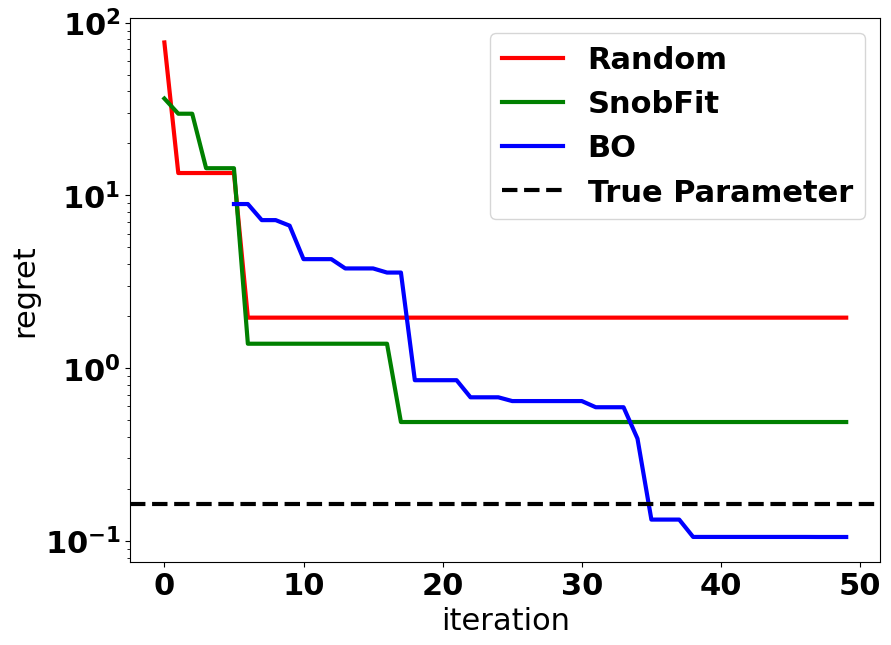

In [ ]:
best = np.array(19.0826) # best solution found over 100 rounds of optimization
fig= plt.figure(figsize=(10,8))
plt.plot( RD_losses.numpy().flatten()-best, c='r', label='Random', lw=3)
plt.plot( SF_losses.numpy().flatten()-best, c='g', label='SnobFit', lw=3)
plt.plot(np.arange(n_init, total_evals), BO_losses.numpy().flatten()-best, c='b', label='BO', lw=3)
plt.axhline(True_Score-best, linestyle='--', c='k', label='True Parameter', lw=3)
plt.xlabel('iteration')
plt.ylabel('regret')
plt.subplots_adjust(left=.15, bottom=.2)
plt.legend()
plt.yscale("log")

plt.show()

In [ ]:
# See best training 


#run sims
theta_1_sims = []
thetas_good = []
thetas_bad = []
thetas_sf = []

J_learned = 0
J_true = 0
J_bad = 0 
J_sf = 0

for i in range(1):
  J,theta = closedloop_sim(best_x_bo.numpy(),  rand_ic[:,i])
  theta = torch.tensor(theta)
  theta_1_sims.append(theta[:,:]) 
  J_learned += J

  J,theta = closedloop_sim(B_true, rand_ic[:,i])
  theta = torch.tensor(theta)
  thetas_good.append(theta[:,:]) 
  J_true += J
  
  J,theta = closedloop_sim(best_x_rd,  rand_ic[:,i])
  theta = torch.tensor(theta)
  thetas_bad.append(theta[:,:]) 
  J_bad += J

  J,theta = closedloop_sim(best_x_sf,  rand_ic[:,i])
  theta = torch.tensor(theta)
  thetas_sf.append(theta[:,:]) 
  J_sf += J


print("Average perfomance of True control parameters = ", J_true)
print("Average perfomance of learned control parameters = ", J_learned)
print("Average perfomance of SF control parameters = ", J_sf)
print("Average perfomance of RND control parameters = ", J_bad)



Average perfomance of True control parameters =  19.24608719529267
Average perfomance of learned control parameters =  19.187877747318385
Average perfomance of SF control parameters =  19.57003577137569
Average perfomance of RND control parameters =  21.042256096453613


Text(0, 0.5, '$x_1$ ')

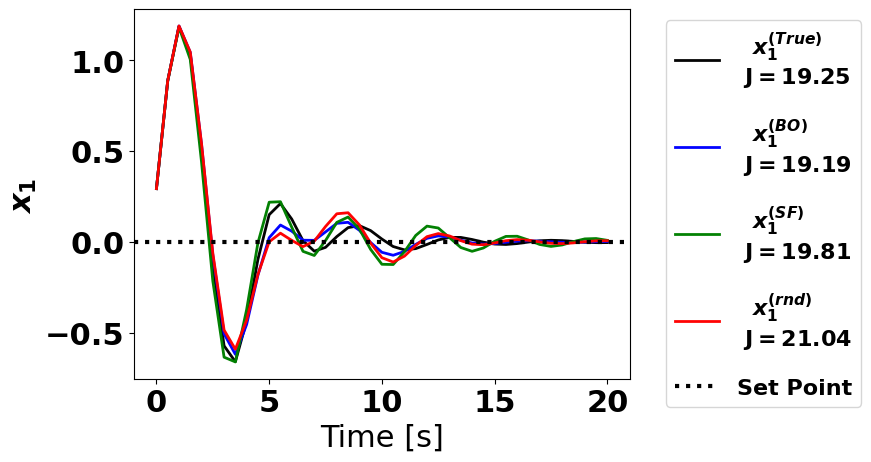

In [ ]:
# See best training 

fig = plt.figure()

plt.plot(np.arange(41)*0.5, thetas_good[i][:,0], 'k-', alpha = .99, label="{} \n {}".format(r"  $x^{(True)}_1$", r"J$= 19.25$"), lw = 2)
plt.plot(np.arange(41)*0.5, theta_1_sims[i][:,0], 'b-', alpha = .99, label="{} \n {}".format(r"  $x^{(BO)}_1$", r"J$= 19.19$"), lw = 2)
plt.plot(np.arange(41)*0.5, thetas_bad[i][:,0], 'g-', alpha = .99, label="{} \n {}".format(r"  $x^{(SF)}_1$", r"J$= 19.81$"), lw = 2)
plt.plot(np.arange(41)*0.5, thetas_sf[i][:,0], 'r-', alpha = .99, label="{} \n {}".format(r"  $x^{(rnd)}_1$", r"J$= 21.04$"), lw = 2)
plt.axhline(0, linestyle=':', c='k', label='Set Point', lw=3)


plt.legend(bbox_to_anchor=(1.05,1), labelspacing=1.2, fontsize="16")
plt.xlabel('Time [s]')
plt.ylabel(r'$x_1$ ')

Text(0, 0.5, '$x_2$ ')

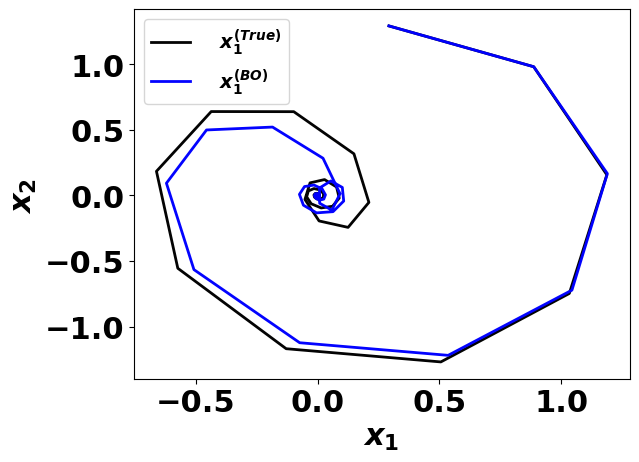

In [ ]:
fig = plt.figure()

plt.plot(thetas_good[i][:,0], thetas_good[i][:,1], 'k-', alpha = .99, label=r"  $x^{(True)}_1$", lw = 2)
plt.plot(theta_1_sims[i][:,0], theta_1_sims[i][:,1], 'b-', alpha = .99, label="  $x^{(BO)}_1$",  lw = 2)

plt.legend( fontsize="14")
plt.xlabel(r'$x_1$ ')
plt.ylabel(r'$x_2$ ')


In [ ]:
# closed loop verification

theta_0_samples =  torch.tensor([2,-1,0,-2])

#run sims
theta_1_sims = []
thetas_good = []
thetas_bad = []
thetas_sf = []

J_learned = 0
J_true = 0
J_bad = 0 
J_sf = 0

for i in range(1):
  J,theta = closedloop_sim(best_x_bo.numpy(),  specified_theta0=theta_0_samples)
  theta = torch.tensor(theta)
  theta_1_sims.append(theta[:,:]) 
  J_learned += J

  J,theta = closedloop_sim(B_true, specified_theta0=theta_0_samples)
  theta = torch.tensor(theta)
  thetas_good.append(theta[:,:]) 
  J_true += J
  
  J,theta = closedloop_sim(best_x_rd,  specified_theta0=theta_0_samples)
  theta = torch.tensor(theta)
  thetas_bad.append(theta[:,:]) 
  J_bad += J

  J,theta = closedloop_sim(best_x_sf,  specified_theta0=theta_0_samples)
  theta = torch.tensor(theta)
  thetas_sf.append(theta[:,:]) 
  J_sf += J


print("Average perfomance of True control parameters = ", J_true)
print("Average perfomance of learned control parameters = ", J_learned)
print("Average perfomance of SF control parameters = ", J_sf)
print("Average perfomance of RND control parameters = ", J_bad)




Average perfomance of True control parameters =  164.32268098659824
Average perfomance of learned control parameters =  165.41135425270662
Average perfomance of SF control parameters =  167.19186599200378
Average perfomance of RND control parameters =  183.3491649673441


Text(0, 0.5, '$x_1$ ')

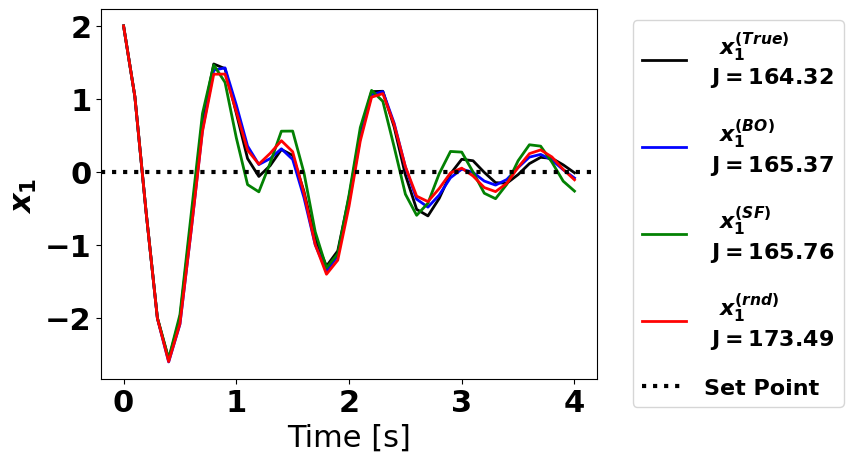

In [ ]:
## New IC
fig = plt.figure()

plt.plot(np.arange(41)*0.1, thetas_good[i][:,0], 'k-', alpha = .99, label="{} \n {}".format(r"  $x^{(True)}_1$", r"J$= 164.32$"), lw = 2)
plt.plot(np.arange(41)*0.1, theta_1_sims[i][:,0], 'b-', alpha = .99, label="{} \n {}".format(r"  $x^{(BO)}_1$", r"J$= 165.37$"), lw = 2)
plt.plot(np.arange(41)*0.1, thetas_bad[i][:,0], 'g-', alpha = .99, label="{} \n {}".format(r"  $x^{(SF)}_1$", r"J$= 165.76$"), lw = 2)
plt.plot(np.arange(41)*0.1, thetas_sf[i][:,0], 'r-', alpha = .99, label="{} \n {}".format(r"  $x^{(rnd)}_1$", r"J$= 173.49$"), lw = 2)
plt.axhline(0, linestyle=':', c='k', label='Set Point', lw=3)


plt.legend(bbox_to_anchor=(1.05,1), labelspacing=1.2, fontsize="16" )
plt.xlabel('Time [s]')
plt.ylabel(r'$x_1$ ')

In this example, we run just a single round of optimization to get a flavor of MPC tunning. We also ran 50 rounds of optimization, to provide a statistical convergence analysis.

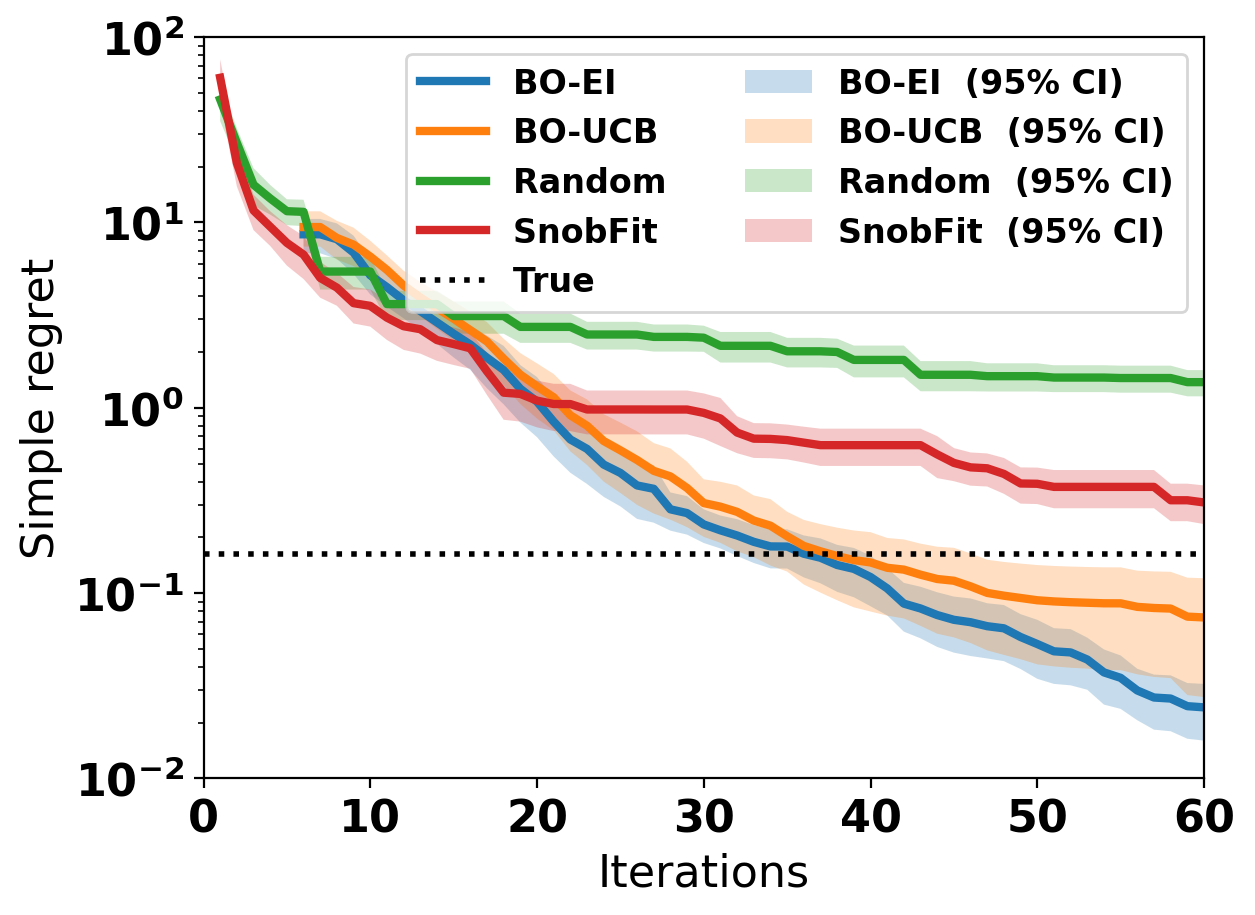